# LLM Evaluation & Prompt Testing

## Current System Overview

### RAG Pipeline Architecture

**Purpose**: An AI civics tutor that evaluates user answers for the USCIS citizenship test and provides educational feedback.

**Components**:
1. **Question Bank**: Official USCIS civics test questions with up-to-date correct answers
2. **Vector Database**: Qdrant containing embedded USCIS Civics Guide passages
3. **Retrieval**: Semantic search retrieves relevant context from civics guide
4. **LLM Evaluation**: OpenAI model evaluates answer and generates educational feedback

**System Inputs**:
- **Question**: The civics test question being asked
- **Correct Answers**: Up-to-date acceptable answers (updated monthly via automated ingestion)
- **User Answer**: The student's submitted answer
- **Context**: Retrieved passages from USCIS Civics Guide (2-4 chunks via RAG)
- **User State**: Student's location for state-specific questions (governor, senators, etc.)

**System Outputs**:
The bot returns a JSON response with three fields:

1. **`success`** (boolean): Pass/fail evaluation of the user's answer
2. **`reason`** (string): Explanation for why the answer passed or failed
3. **`background_info`** (string): Educational context to help student learn and retain information

**Optimal RAG Configuration** (from the retrieval evaluation analysis (here)[./04_retrieval_evaluation.ipynb]):
- Context limit: 4 chunks
- success threshold: 0.3
- Query expansion: False
- Temperature: 0.5

---

## Current Problems Identified

### Problem 1: LLM Using Outdated Training Data Instead of Provided Answers
**Description**: The LLM sometimes relies on its training data instead of the correct answers explicitly provided in the prompt.

**Critical Example**:
- **Question**: "Who is the current US President?"
- **Provided correct answer**: "Donald Trump" (from monthly-updated data ingestion)
- **User answer**: "Donald Trump"
- **LLM behavior**: Marks answer as **INCORRECT** because LLM was trained on 2024 data when Biden was president
- **Root cause**: LLM ignoring the `answers` parameter and using its outdated world knowledge

**Impact**: 
- System gives wrong evaluations for time-sensitive questions (presidents, governors, senators, representatives)
- Defeats the purpose of monthly automated data updates
- Users get marked wrong when they're actually correct

**Affected question types**:
- Current officeholders (president, VP, governors, senators, representatives)
- Any time-sensitive civics information that changes

---

### Problem 2: Grading Too Harsh
**Description**: The evaluation is overly strict and marks semantically correct answers as wrong.

**Examples**:
- ❌ User makes minor **typos** but answer is semantically correct → marked as fail
- ❌ Question asks for **2 answers**, user provides **3 answers** where 2 are correct → marked as fail  
- ❌ User answer is **semantically equivalent** but doesn't use exact wording → marked as fail

**Example**:
- Correct answer: "freedom of speech"
- User answer: "fredom of speach" (typos) → marked wrong
- User answer: "right to free speech" (equivalent) → marked wrong

**Impact**: Students get discouraged when correct answers are marked wrong due to technicalities.

---

### Problem 3: Background Info Too Short/Generic
**Description**: The background information often lacks educational depth and substance.

**Symptoms**:
- Background info is only 1-2 sentences (too short to be educational)
- Information appears generic and doesn't leverage the retrieved context
- Students report feeling like they "learned nothing" from the background

**Current prompt guidance**: "Keep background info short" (likely contributing to this issue)

**Impact**: Defeats the learning purpose - students don't retain information beyond rote memorization.

---

### Problem 4: Poor Context Utilization
**Description**: Unclear whether the LLM actually uses the retrieved RAG context to generate background info.

**Observation**: Some background info appears generic enough that it could have been generated without any context retrieval.

**Impact**: 
- Wastes the RAG pipeline effort
- Missing opportunity to provide authoritative, context-grounded education
- Background info lacks depth and specificity

---

### Problem 5: Redundancy Between Reason & Background
**Description**: The `reason` and `background_info` fields often contain overlapping or repetitive information.

**Example**:
```json
{
  "reason": "Your answer is correct. The three branches of government are legislative, executive, and judicial.",
  "background_info": "The U.S. government has three branches: legislative, executive, and judicial. This separation ensures checks and balances."
}
```

**Impact**: 
- Wastes tokens and API costs
- Poor user experience (feels repetitive)
- Background info doesn't add value beyond the reason

---

## Evaluation Goals

### Primary Objectives

1. **Fix Training Data Override Issue** 🔴 **CRITICAL**
   - Ensure LLM strictly uses provided `answers` parameter, not its training data
   - Test with time-sensitive questions (current president, governors, etc.)
   - Success metric: 100% accuracy on questions with outdated training data

2. **Reduce Harsh Grading**
   - Accept answers with minor typos (high edit distance similarity)
   - Accept semantically equivalent answers (same meaning, different words)
   - Pass answers for multi-part questions when some parts are correct and satisfied the min number of given correct values in list
   - Success metric: bot passing answers where 3 given, 2 min needed, and 2/3 were correct. Measured via llm-as-judge grading accuracy

3. **Improve Background Info Quality**
   - Increase substantive length (target: 50-80 words minimum)
   - Ensure educational value and learning retention
   - Success metric: Average word count ≥50, higher LLM-as-judge successs

4. **Ensure Context Usage**
   - Background info must demonstrably use retrieved RAG context
   - Include specific facts/details from context passages
   - Success metric: High context overlap ratio, LLM-as-judge confirms context usage

5. **Eliminate Redundancy**
   - Make `reason` and `background_info` distinct and complementary
   - `reason` = explain grading decision
   - `background_info` = teach something new beyond grading
   - Success metric: Reason-background similarity success <0.5

### Success Criteria Summary
We are going to explore the following metrics and see their trends given changes in prompt
#### Quantitative metrics
- positive feedback rate
- background word count
- context usage in background
- reason-background similarity
#### Qualitative metrics (LLM-as-judge)
- Grading use of context
- Grading accuracy
- Background info quality
- Background use of context


## Procedure
We will focus right now on the 2008 test, for arizona. For two reasons: I am from AZ, and the 2008 test is the one all people are taking right now since oct 20 has not yet passed.

We will:
1. Try out the current exam setup ~50 times to create a golden dataset with actual feedback.
2. check out the basic quantitative metrics to see how we're doing... and if we indeed are seeing consistently some of the issues mentioned above
3. Try out LLM-as-judge to check the qualitative metrics that should give us insight into our overall performance
4. Log our current 'base' successs
5. Try out some prompt changes
6. see if our metrics improve/worsen
7. settle on the best prompt out there.

NOTE: that on this notebook we will focus on steps 1-4, to establish the base and the best evaluation setup. The rest of the steps will be done via monitoring and further prompt refinement.

In [4]:
import pandas as pd
import psycopg2
from dotenv import load_dotenv
import os

In [5]:

# Load environment variables from .env file
load_dotenv()

# Get the database URL
DATABASE_URL = os.getenv('DATABASE_URL')

# Connect to Neon
conn = psycopg2.connect(DATABASE_URL)
print("✅ Connected to Neon!")


✅ Connected to Neon!


In [6]:
# Load feedback data
df = pd.read_sql("""
    SELECT * FROM feedback 
    ORDER BY timestamp DESC
""", conn)

print(f"Total feedback entries: {len(df)}")
df.head()

/var/folders/bq/bvtwklb14vs146h6cdng_jvm0000gq/T/ipykernel_68793/2171077951.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("""


Total feedback entries: 70


,id,timestamp,user_state,test_year,question_text,correct_answers,user_answer,success,reason,background_info,feedback_type,session_id,rag_context_limit,rag_score_threshold,rag_query_expansion,system_prompt,user_prompt,model,llm_temperature,context
0,70,2025-10-16 23:12:25.165481,Arizona,2008,What does the President’s Cabinet do?,"{""advises the President""}",they advice the president on their area of exp...,False,Almost there! The correct answer is that the P...,The President’s Cabinet is like a secret sauce...,positive,08eee2c4-7a3c-434d-b7d8-b219e6acef5d,4,0.3,False,\nYou are a friendly USCIS officer helping the...,\n<question>\nWhat does the President’s Cabine...,gpt-4o-mini,0.5,Page 13:\nTHE EXECUTIVE BRANCH\nIn this chapte...
1,69,2025-10-16 23:12:01.025205,Arizona,2008,Who does a U.S. Senator represent?,"{""all people of the state""}",their state,False,"Close, but not quite! A U.S. Senator represent...","Each state has two U.S. Senators, so it’s like...",positive,08eee2c4-7a3c-434d-b7d8-b219e6acef5d,4,0.3,False,\nYou are a friendly USCIS officer helping the...,\n<question>\nWho does a U.S. Senator represen...,gpt-4o-mini,0.5,Page 11:\nElecting Members of the House of Rep...
2,68,2025-10-16 23:10:41.910605,Arizona,2008,Why do some states have more Representatives t...,"{""(because of) the state’ s population"",""(beca...",some states they got more people than othersta...,False,"Close, but not quite! The correct answer is th...",Did you know that California has 52 representa...,negative,08eee2c4-7a3c-434d-b7d8-b219e6acef5d,4,0.3,False,\nYou are a friendly USCIS officer helping the...,\n<question>\nWhy do some states have more Rep...,gpt-4o-mini,0.5,Page 10:\nTHE LEGISLATIVE BRANCH (CONGRESS)\nI...
3,67,2025-10-16 23:10:05.985411,Arizona,2008,What is the economic system in the United States?,"{""capitalist economy"",""market economy""}",capitalism economy,False,"Close, but not quite! The correct terms are 'c...","In a market economy, the government doesn’t co...",negative,08eee2c4-7a3c-434d-b7d8-b219e6acef5d,4,0.3,False,\nYou are a friendly USCIS officer helping the...,\n<question>\nWhat is the economic system in t...,gpt-4o-mini,0.5,Page 32:\nAMERICAN HISTORY: 1900-2001\nIn this...
4,66,2025-10-16 23:09:46.921651,Arizona,2008,When is the last day you can send in federal i...,"{""April 15""}",apr 15,True,Correct! The last day to send in federal incom...,"If April 15 falls on a weekend or holiday, the...",positive,08eee2c4-7a3c-434d-b7d8-b219e6acef5d,4,0.3,False,\nYou are a friendly USCIS officer helping the...,\n<question>\nWhen is the last day you can sen...,gpt-4o-mini,0.5,No relevant context found.


## Quantitative metrics

In [7]:
# function to get positive feedback rate
def get_positive_feedback_rate(df):
    """
    Calculate the percentage of positive feedback.
    
    Args:
        df: DataFrame with 'feedback_type' column containing 'positive' or 'negative'
    
    Returns:
        float: Percentage of positive feedback (0-100)
    """
    positive_count = (df['feedback_type'] == 'positive').sum()
    total_count = len(df)
    
    if total_count == 0:
        return 0.0
    
    return (positive_count / total_count) * 100

In [8]:
def add_background_word_count(df):
    """
    Add background_word_count column to DataFrame.
    
    Args:
        df: DataFrame with 'background_info' column
    
    Returns:
        DataFrame: Original DataFrame with new 'background_info_word_count' column added
    """
    df['background_info_word_count'] = df['background_info'].str.split().str.len()
    return df

In [9]:
def calculate_context_usage(df):
    """
    Calculate what percentage of context words appear in background_info.
    
    Returns:
        Series: Context usage ratio for each row (0-1)
    """
    def word_overlap_ratio(row):
        # Get words from context and background
        context_words = set(str(row['context']).lower().split())
        background_words = set(str(row['background_info']).lower().split())
        
        # Remove common stop words to focus on meaningful overlap
        stop_words = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'is', 'are', 'was', 'were', 'page'}
        context_words -= stop_words
        background_words -= stop_words
        
        # Calculate overlap
        if len(context_words) == 0:
            return 0.0
        
        overlap = len(context_words & background_words)
        return overlap / len(context_words)
    
    return df.apply(word_overlap_ratio, axis=1)

def calculate_ngram_overlap(df, n=3):
    """
    Calculate overlap of n-grams between context and background.
    Better at catching actual usage vs coincidental word matches.
    """
    from collections import Counter
    
    def get_ngrams(text, n):
        words = text.lower().split()
        return set([' '.join(words[i:i+n]) for i in range(len(words)-n+1)])
    
    def ngram_overlap_ratio(row):
        context_ngrams = get_ngrams(str(row['context']), n)
        background_ngrams = get_ngrams(str(row['background_info']), n)
        
        if len(context_ngrams) == 0:
            return 0.0
        
        overlap = len(context_ngrams & background_ngrams)
        return overlap / len(context_ngrams)
    
    return df.apply(ngram_overlap_ratio, axis=1)

def calculate_key_term_usage(df):
    """
    Check if key terms from context appear in background.
    Focuses on proper nouns, numbers, and capitalized terms.
    """
    import re
    
    def extract_key_terms(text):
        # Find capitalized words (likely proper nouns)
        capitalized = set(re.findall(r'\b[A-Z][a-z]+(?:\s+[A-Z][a-z]+)*\b', text))
        # Find numbers
        numbers = set(re.findall(r'\b\d+\b', text))
        # Find words in quotes
        quoted = set(re.findall(r'"([^"]*)"', text))
        
        return capitalized | numbers | quoted
    
    def key_term_ratio(row):
        context_terms = extract_key_terms(str(row['context']))
        background_text = str(row['background_info']).lower()
        
        if len(context_terms) == 0:
            return 0.0
        
        # Check how many key terms appear in background
        found = sum(1 for term in context_terms if term.lower() in background_text)
        return found / len(context_terms)
    
    return df.apply(key_term_ratio, axis=1)

In [10]:
def analyze_context_usage(df):
    """
    Comprehensive context usage analysis using multiple metrics.
    """
    # Word overlap
    df['word_overlap'] = calculate_context_usage(df)
    
    # 3-gram overlap (phrases)
    df['phrase_overlap'] = calculate_ngram_overlap(df, n=3)
    
    # Key terms
    df['key_term_usage'] = calculate_key_term_usage(df)
    
    # Summary stats
    stats = {
        'word_overlap_mean': df['word_overlap'].mean(),
        'phrase_overlap_mean': df['phrase_overlap'].mean(),
        'key_term_usage_mean': df['key_term_usage'].mean(),
        'low_usage_count': len(df[df['word_overlap'] < 0.3])  # Flag low usage
    }
    
    return df, stats

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

def add_reason_background_similarity(df):
    """
    Calculate cosine similarity between reason and background_info using TF-IDF.
    Adds 'reason_bkg_info_similarity' column to DataFrame.
    
    Args:
        df: DataFrame with 'reason' and 'background_info' columns
    
    Returns:
        DataFrame: Original DataFrame with new 'reason_bkg_info_similarity' column added
    """
    similarities = []
    
    for idx, row in df.iterrows():
        reason = str(row['reason'])
        background = str(row['background_info'])
        
        # Create TF-IDF vectors
        vectorizer = TfidfVectorizer()
        try:
            tfidf_matrix = vectorizer.fit_transform([reason, background])
            similarity = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]
        except:
            similarity = 0.0  # Handle edge cases
        
        similarities.append(similarity)
    
    df['reason_bkg_info_similarity'] = similarities
    return df

In [12]:
# add to df the word count
df = add_background_word_count(df)


positive_rate = get_positive_feedback_rate(df)
print(f"Positive Feedback Rate: {positive_rate:.1f}%")
print(f"Average: {df['background_info_word_count'].mean():.1f} words")
print(f"Range: {df['background_info_word_count'].min()} - {df['background_info_word_count'].max()} words")

Positive Feedback Rate: 70.0%
Average: 29.5 words
Range: 16 - 49 words


In [13]:
df_usage, usage_stats = analyze_context_usage(df)
df = add_reason_background_similarity(df)

print("Context Usage Analysis:")
print(f" Mean Word overlap: {usage_stats['word_overlap_mean']:.1%}")
print(f" Mean Phrase overlap: {usage_stats['phrase_overlap_mean']:.1%}")
print(f" Mean Key term usage: {usage_stats['key_term_usage_mean']:.1%}")
print(f" Mean Low usage cases (word overlap < 30%): {usage_stats['low_usage_count']}")

# Analyze
print(f"Mean similarity: {df['reason_bkg_info_similarity'].mean():.2f}")
print(f"High redundancy (>0.5): {len(df_usage[df_usage['reason_bkg_info_similarity'] > 0.5])}")

Context Usage Analysis:
 Mean Word overlap: 2.6%
 Mean Phrase overlap: 0.4%
 Mean Key term usage: 9.1%
 Mean Low usage cases (word overlap < 30%): 70
Mean similarity: 0.25
High redundancy (>0.5): 1


#### Quick analysis on quantitative values
- Feedack rate: `70% is positive`. We can do better... lots of negative feedback come from the issues described above.
- Background length: 16-49 words with an average of `~30 words`.
- context usage: analyzed 3 metrics. Somewhat best (and its not great already) is word overlap. It gives an `avg word overlap of 2.6%`. May be better to analyze this with llm.
- reason/background similarity: used cosine similarity between reason and background info. We get a mean of 0.25 (`25%`). Not a lot of redundancy. should be good? lets confirm with llm.

## LLM as judge

In [14]:
LLM_JUDGE_SYSTEM_PROMPT = """ 
You are an expert evaluator for an AI civics tutor chatbot powered by a Retrieval-Augmented Generation (RAG) pipeline. 
This chatbot helps students practice for the USCIS citizenship test. 
Your role is to judge how well the chatbot’s outputs adhere to its intended logic and data sources. 

---

### BOT CONTEXT

The chatbot receives the following inputs:
- **question**: The USCIS civics test question being asked.
- **answers**: The authoritative list of acceptable answers. These are regularly updated and must override the model’s own outdated world knowledge.
- **user_state**: The student’s U.S. state (used for state-specific questions).
- **user_answer**: The student’s submitted answer.
- **context**: 2–4 retrieved passages from the official USCIS Civics Guide.

The chatbot produces this output:
- **success** (boolean): Whether the user’s answer was marked correct or incorrect.
- **reason** (string): The rationale for the pass/fail result.
- **background_info** (string): Additional educational information drawn from the RAG context to help the user learn more about the topic.

---

### YOUR TASK

Given the chatbot’s inputs and outputs, evaluate each of the following **independently** and **objectively**.  
Use only the provided data — ignore any external or world knowledge.

---

#### 1. `answer_context_usage` (yes / no)
**Goal:** Determine if the chatbot used the provided `answers` list correctly, rather than relying on outdated training data.  
- **YES** → The chatbot clearly uses the `answers` field to judge correctness, even if that data differs from current real-world facts.  
- **NO** → The chatbot ignores the `answers` field and instead uses its own outdated or internal world knowledge.

**Examples:**
- ✅ **Yes:**  
  - Question: “Who is the U.S. President?”  
    answers: ["Donald Trump"]  
    user_answer: "Donald Trump"  
    chatbot marks as **success: true** and reason references the provided answer list.  
- ❌ **No:**  
  - Question: “Who is the U.S. President?”  
    answers: ["Donald Trump"]  
    user_answer: "Donald Trump"  
    chatbot marks as **success: false** because it claims the president is Biden — indicating outdated world knowledge.

---

#### 2. `grading_accuracy` (good / bad)
**Goal:** Assess whether the chatbot graded fairly and reasonably, without being overly strict.  
- **GOOD** → The chatbot accepts minor spelling mistakes, semantically equivalent answers, and allows for correct multi-part answers even with extra items.  
- **BAD** → The chatbot penalizes minor typos, ignores semantic equivalence, or fails multi-part answers even when enough correct items are present.

**Examples:**
- ✅ **Good:**  
  - Question: “What is one right of the people?”  
    answers: ["freedom of speech", "freedom of assembly"]  
    user_answer: "right to free speech"  
    chatbot passes the answer and explains semantic equivalence.  
- ✅ **Good:**  
  - Question: “Name two states that border Mexico.”  
    answers: ["Texas", "Arizona", "California", "New Mexico"]  
    user_answer: "Arizona, California, Michigan"  
    chatbot passes since two of three are correct and notes Michigan is unrelated.  
- ❌ **Bad:**  
  - Question: “Name one war fought by the U.S. in the 1900s.”  
    answers: ["World War I", "World War II", "Korean War"]  
    user_answer: "world war one"  
    chatbot fails it because of wording or capitalization.  
- ❌ **Bad (typo/misspelling case):**  
  - Question: “What is one freedom from the First Amendment?”  
    answers: ["freedom of speech", "freedom of religion", "freedom of assembly"]  
    user_answer: "fredom of speach"  
    chatbot marks **success: false** — this is **bad grading**, since the user’s intent is clear despite spelling errors.

---

#### 3. `background_info_quality` (good / bad)
**Goal:** Judge the educational value and distinctiveness of the chatbot’s `background_info`.  
- **GOOD** → The background provides meaningful educational content that adds new information beyond the `reason`.  
- **BAD** → The background merely restates the reason, or is too generic/uninformative.

**Examples:**
- ✅ **Good:**  
  - Question: “Who was president during World War I?”  
    reason: “Correct. Woodrow Wilson was president during World War I.”  
    background_info: “Wilson led the U.S. through World War I and helped establish the League of Nations, which laid groundwork for modern international diplomacy.”  
- ❌ **Bad:**  
  - Same question, background_info: “Woodrow Wilson was president during World War I.”  
    (This repeats the reason and adds no educational value.)

---

#### 4. `background_context_usage` (yes / no)
**Goal:** Determine if the chatbot’s `background_info` actually uses information from the retrieved RAG `context`.  
- **YES** → The background includes facts, examples, or phrasing that clearly derive from the context passages.  
- **NO** → The background is generic or unrelated to the retrieved text.

**Examples:**
- ✅ **Yes:**  
  - Context mentions that “the President signs bills into law.”  
    background_info: “The President plays a key role in the legislative process by signing bills into law, a power described in the Constitution.”  
- ❌ **No:**  
  - Context is detailed, but background_info says only: “The President is the leader of the country.”  

---

### EVALUATION GUIDELINES

- Evaluate **each metric independently** — a “good” in one does not affect others.  
- Use **only** the provided `question`, `answers`, `user_answer`, `context`, and chatbot outputs.  
- **Do not** use or infer from your own training data or current world knowledge.  
- Keep reasons **short and specific** (1–2 sentences).  
- Include a **confidence score (0–1)** for each metric based on how certain you are.  
- Output must be **strictly valid JSON** — no extra text, explanations, or formatting outside of the JSON object.

---

### OUTPUT FORMAT

```json
{
  "answer_context_usage": "yes" | "no",
  "answer_context_usage_reason": "string",
  "answer_context_usage_confidence": 0.0,
  "grading_accuracy": "good" | "bad",
  "grading_accuracy_reason": "string",
  "grading_accuracy_confidence": 0.0,
  "background_info_quality": "good" | "bad",
  "background_info_quality_reason": "string",
  "background_info_quality_confidence": 0.0,
  "background_context_usage": "yes" | "no",
  "background_context_usage_reason": "string",
  "background_context_usage_confidence": 0.0
}
"""

In [15]:

LLM_JUDGE_USER_PROMPT = """
Evaluate the following chatbot interaction **independently for each criterion**.

---

### BOT INPUT:
<question>
{question}
</question>

<answers>
{answers}
</answers>

<user_state>
{user_state}
</user_state>

<user_answer>
{user_answer}
</user_answer>

<context>
{context}
</context>

---

### BOT OUTPUT:
<success>
{success}
</success>

<reason>
{reason}
</reason>

<background_info>
{background_info}
</background_info>
"""

In [16]:
import sys
sys.path.append('..')

import time
from utils import llm
from tqdm import tqdm

In [17]:
def run_llm_evaluation(df, model='gpt-4o-mini', temperature=0.5, delay=0.5):
    """ 
    Run llm-as-judge given a model and a temperature. Returns an updated df.
    Note: internally we are populating via user prompt all the background information of that qna
    
    Args:
        df: DataFrame with feedback data
        model: OpenAI model to use (default: gpt-4o-mini)
        temperature: Temperature for LLM (default: 0.5)
        delay: Seconds to wait between API calls to avoid rate limits (default: 0.5)
    
    Returns:
        DataFrame: Copy of original DataFrame with LLM judge columns added
    """
    # Work on a copy to avoid modifying original
    df = df.copy()
    
    evaluations = []
    errors = []

    # Loop through each row with progress bar
    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Running {model} evaluations"):
        
        try:
            # Format the user prompt with row data
            llm_judge_user_prompt_formatted = LLM_JUDGE_USER_PROMPT.format(
                question=row['question_text'],
                answers=row['correct_answers'],
                user_state=row['user_state'],
                user_answer=row['user_answer'],
                success=row['success'],
                reason=row['reason'],
                background_info=row['background_info'],
                context=row['context'],
            )
            
            # Call the LLM
            evaluation = llm(
                system_prompt=LLM_JUDGE_SYSTEM_PROMPT,
                user_prompt=llm_judge_user_prompt_formatted,
                model=model,
                temperature=temperature
            )
            
            # Check if LLM returned an error
            if 'error' in evaluation:
                print(f"\n⚠️  Row {idx}: LLM returned error - {evaluation.get('error', 'Unknown error')}")
                errors.append({'idx': idx, 'error': evaluation.get('error', 'Unknown error')})
            
            evaluations.append(evaluation)
            
            # Add delay to avoid rate limits
            time.sleep(delay)
            
        except KeyError as e:
            # Handle missing keys in format string
            print(f"\n❌ Row {idx}: Missing required field - {e}")
            errors.append({'idx': idx, 'error': f'Missing field: {e}'})
            evaluations.append({})
            
        except Exception as e:
            # Catch all other exceptions
            print(f"\n❌ Row {idx}: Unexpected error - {e}")
            errors.append({'idx': idx, 'error': str(e)})
            evaluations.append({})

    # Parse evaluations and add as columns (raw values, no conversion)
    df['llm_judge_answer_context_usage'] = [e.get('answer_context_usage', None) for e in evaluations]
    df['llm_judge_answer_context_usage_reason'] = [e.get('answer_context_usage_reason', '') for e in evaluations]
    df['llm_judge_answer_context_usage_confidence'] = [e.get('answer_context_usage_confidence', None) for e in evaluations]

    df['llm_judge_grading_accuracy'] = [e.get('grading_accuracy', None) for e in evaluations]
    df['llm_judge_grading_accuracy_reason'] = [e.get('grading_accuracy_reason', '') for e in evaluations]
    df['llm_judge_grading_accuracy_confidence'] = [e.get('grading_accuracy_confidence', None) for e in evaluations]

    df['llm_judge_background_info_quality'] = [e.get('background_info_quality', None) for e in evaluations]
    df['llm_judge_background_info_quality_reason'] = [e.get('background_info_quality_reason', '') for e in evaluations]
    df['llm_judge_background_info_quality_confidence'] = [e.get('background_info_quality_confidence', None) for e in evaluations]

    df['background_context_usage'] = [e.get('background_context_usage', None) for e in evaluations]
    df['background_context_usage_reason'] = [e.get('background_context_usage_reason', '') for e in evaluations]
    df['background_context_usage_confidence'] = [e.get('background_context_usage_confidence', None) for e in evaluations]
    
    # Store raw evaluations for reference
    df['llm_judge_raw'] = evaluations
    
    # Print summary
    print(f"\n{'='*50}")
    print(f"✅ Completed {len(evaluations)} evaluations with {model}")
    print(f"   Temperature: {temperature}")
    print(f"   Delay: {delay}s per request")
    
    if errors:
        print(f"\n⚠️  Encountered {len(errors)} errors:")
        for err in errors[:5]:  # Show first 5 errors
            print(f"   - Row {err['idx']}: {err['error']}")
        if len(errors) > 5:
            print(f"   ... and {len(errors) - 5} more errors")
    else:
        print(f"   No errors! 🎉")
    
    print(f"{'='*50}\n")
    
    return df

In [18]:
# running under two different models
df_eval_gpt_4o_mini = run_llm_evaluation(df,model='gpt-4o-mini',temperature=0.2,delay=0.5)
df_eval_gpt_4o = run_llm_evaluation(df,model='gpt-4o',temperature=0.2,delay=1.0)


Running gpt-4o-mini evaluations: 100%|██████████| 70/70 [12:07<00:00, 10.39s/it] 



✅ Completed 70 evaluations with gpt-4o-mini
   Temperature: 0.2
   Delay: 0.5s per request
   No errors! 🎉



Running gpt-4o evaluations: 100%|██████████| 70/70 [37:26<00:00, 32.09s/it]   


✅ Completed 70 evaluations with gpt-4o
   Temperature: 0.2
   Delay: 1.0s per request
   No errors! 🎉



### Plotting and interpreting the data
As a quick recap, we are using llm-as-judge to evaluate the following metrics:

- Grading use of context (answer_context_usage) : did the grading use the valid list of answers, which contains the most up to date answers per question?
- Grading accuracy (grading_accuracy) : is the grading good, actually?
- Background info quality (background_info_quality) : is the "did you know?" portion actually educational?
- Background use of context (background_context_usage): is the "did you know" portion actually making use of RAG or not?
  
Now, the user (for now just me), gave some thumbs up/thumbs down feedback where they basically assessed how good bad was the grading, and if the answer matched the context given in the official "answers list".

In the wild users may potentially use the feedback to comment on the quality/usefulness of the background info, but in general, it is safe to assume that a user would most likely just rate this if they felt the grading was unfair.

So with that, we focus our efforts on just looking at the first two metrics in a confusion matrix, to see how well the judge aligned with the actual user feedback.

NOTE!: since the user feedback is just a single entry, and does not really distinguish between these different evaluation metrics, we combine these two into one, which in turn represents the user flaggind situations where one or the other (or heck, both) of these metrics were lacking.

So, to see how well the llm-as-judge captures the user sentiment, we plot a confusion matrix for each llm model.

This confusion matrix will tell us two things:
- how well is the llm-as-judge aligning with the user actual feedback.
- Which model is better/worse at agreeing with the users.


We will consider any model to do well if the overall alignment is 75% or greater. I am kinda making up this cutoff, i just think 75% is a good starting point because it means for every 4 questions, 3 get graded well by the bot.

In [31]:
# plotting the data
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [32]:
# Convert function
def convert_to_binary(value):
    value_str = str(value).lower().strip()
    return 1 if value_str in ['yes', 'good'] else (0 if value_str in ['no', 'bad'] else np.nan)

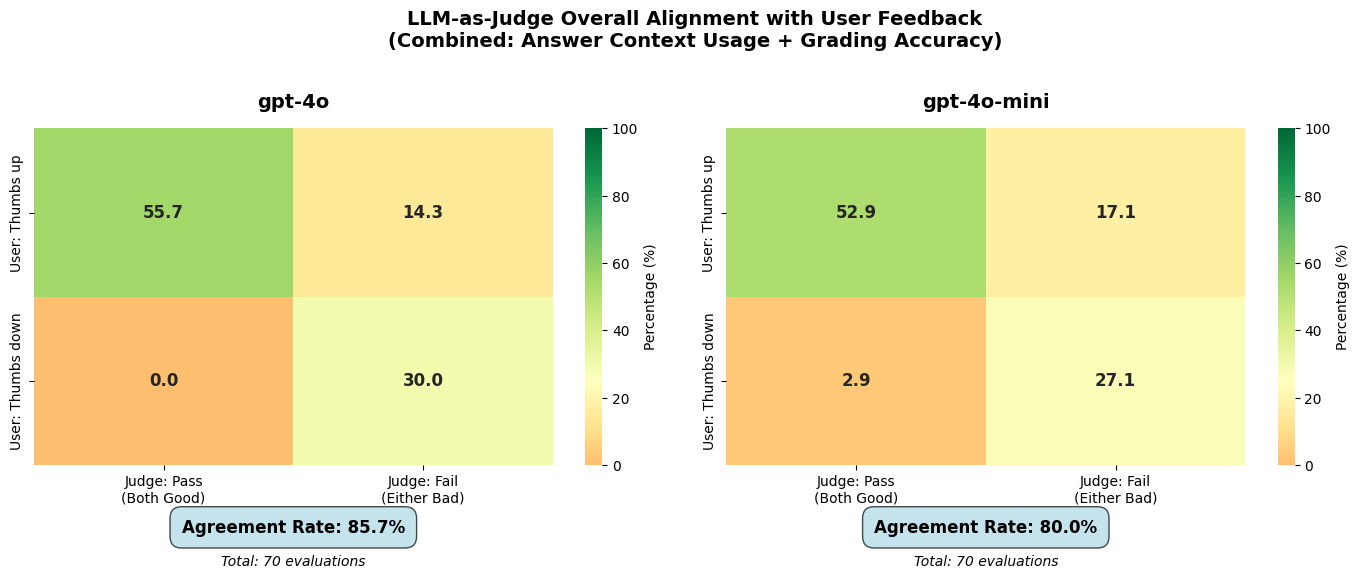


📊 COMBINED FLAG LOGIC

Judge Pass:  Both "Answer Context Usage" = yes/good AND "Grading Accuracy" = good
Judge Fail:  Either metric fails (at least one = no/bad)

This matches how users give feedback - they flag issues when EITHER metric is bad.

🏆 MODEL COMPARISON

Alignment with User Feedback:
  gpt-4o:      85.7%
  gpt-4o-mini: 80.0%

🏆 gpt-4o WINS - Better at capturing user sentiment by 5.7%


In [38]:
# Create 1x2 grid: 2 models side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('LLM-as-Judge Overall Alignment with User Feedback\n(Combined: Answer Context Usage + Grading Accuracy)', 
             fontsize=14, fontweight='bold', y=1.02)

# Models to compare
models = [
    (df_eval_gpt_4o, 'gpt-4o'),
    (df_eval_gpt_4o_mini, 'gpt-4o-mini')
]

# Store agreement rates for comparison
agreement_scores = {}

# Plot one confusion matrix per model
for model_idx, (df_model, model_name) in enumerate(models):
    
    ax = axes[model_idx]
    
    # Work on a copy
    df = df_model.copy()
    
    # Convert both metrics to binary
    df['answer_context_binary'] = df['llm_judge_answer_context_usage'].apply(convert_to_binary)
    df['grading_accuracy_binary'] = df['llm_judge_grading_accuracy'].apply(convert_to_binary)
    
    # Create combined flag:
    # Pass = both metrics pass (both are 1)
    # Fail = either metric fails (at least one is 0)
    df['llm_flag'] = ((df['answer_context_binary'] == 1) & (df['grading_accuracy_binary'] == 1)).astype(int)
    
    # User feedback binary
    df['user_positive'] = (df['feedback_type'] == 'positive').astype(int)
    
    # Create 2x2 confusion matrix
    # User Positive + Judge Pass (both agree it's good)
    both_positive = len(df[(df['user_positive'] == 1) & (df['llm_flag'] == 1)])
    
    # User Positive + Judge Fail (user happy but judge found issues)
    user_pos_judge_neg = len(df[(df['user_positive'] == 1) & (df['llm_flag'] == 0)])
    
    # User Negative + Judge Pass (user unhappy but judge didn't catch it)
    user_neg_judge_pos = len(df[(df['user_positive'] == 0) & (df['llm_flag'] == 1)])
    
    # User Negative + Judge Fail (both agree it's bad)
    both_negative = len(df[(df['user_positive'] == 0) & (df['llm_flag'] == 0)])
    
    # Create confusion matrix
    confusion_matrix = np.array([
        [both_positive, user_pos_judge_neg],
        [user_neg_judge_pos, both_negative]
    ])
    
    # Calculate percentages
    total = confusion_matrix.sum()
    confusion_pct = confusion_matrix / total * 100 if total > 0 else confusion_matrix
    
    # Plot heatmap
    sns.heatmap(confusion_pct, annot=True, fmt='.1f', cmap='RdYlGn', center=25,
                ax=ax, cbar_kws={'label': 'Percentage (%)'}, vmin=0, vmax=100,
                xticklabels=['Judge: Pass\n(Both Good)', 'Judge: Fail\n(Either Bad)'],
                yticklabels=['User: Thumbs up', 'User: Thumbs down'],
                annot_kws={'fontsize': 12, 'fontweight': 'bold'})
    
    ax.set_title(f'{model_name}', fontweight='bold', fontsize=14, pad=15)
    
    # Calculate agreement rate
    agreement = (both_positive + both_negative) / total * 100 if total > 0 else 0
    agreement_scores[model_name] = agreement
    
    # Add agreement rate text below
    ax.text(0.5, -0.2, f'Agreement Rate: {agreement:.1f}%', 
            transform=ax.transAxes, ha='center', fontsize=12, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7, pad=0.7))
    
    # Add count annotations
    ax.text(0.5, -0.3, f'Total: {total} evaluations', 
            transform=ax.transAxes, ha='center', fontsize=10, style='italic')

plt.tight_layout()
plt.savefig('judge_user_alignment_combined.png', dpi=300, bbox_inches='tight')
plt.show()

# Print comparison summary
print("\n" + "="*80)
print("📊 COMBINED FLAG LOGIC")
print("="*80)
print("""
Judge Pass:  Both "Answer Context Usage" = yes/good AND "Grading Accuracy" = good
Judge Fail:  Either metric fails (at least one = no/bad)

This matches how users give feedback - they flag issues when EITHER metric is bad.
""")

print("="*80)
print("🏆 MODEL COMPARISON")
print("="*80)

gpt4o_score = agreement_scores['gpt-4o']
mini_score = agreement_scores['gpt-4o-mini']

print(f"\nAlignment with User Feedback:")
print(f"  gpt-4o:      {gpt4o_score:.1f}%")
print(f"  gpt-4o-mini: {mini_score:.1f}%")

diff = gpt4o_score - mini_score

if abs(diff) < 2:
    print(f"\n⚖️  TIE - Both models capture user sentiment equally well")
elif diff > 0:
    print(f"\n🏆 gpt-4o WINS - Better at capturing user sentiment by {diff:.1f}%")
else:
    print(f"\n🏆 gpt-4o-mini WINS - Better at capturing user sentiment by {abs(diff):.1f}%")

### Outcomes and conclusions
It seems that both llm models are good at capturing user sentiment. Gpt-4o does better by ~6%, but both are above 75%.

So there are two options here:
- Use gpt-4o for an accurate assessment of this chatbot performance.
- Use gpt-4o-mini because it is cheaper.

Looking at the usage page from openai... the cost was ~$.050 cents for using the gpt-4o model for evaluating these 70 points.
So.. assuming we are not expecting high usage later, and we want to have a reliable llm-as-judge, we will go on and use `gpt-4o` for evaluation.

## Performance summary
So what is next? lets see our baseline performance on the bot as-is, from both a quantitative and qualitative perspective.

/var/folders/bq/bvtwklb14vs146h6cdng_jvm0000gq/T/ipykernel_68793/185040166.py:195: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from font(s) DejaVu Sans.
  plt.savefig('metrics_dashboard_gpt4o.png', dpi=300, bbox_inches='tight')
/var/folders/bq/bvtwklb14vs146h6cdng_jvm0000gq/T/ipykernel_68793/185040166.py:195: UserWarning: Glyph 128078 (\N{THUMBS DOWN SIGN}) missing from font(s) DejaVu Sans.
  plt.savefig('metrics_dashboard_gpt4o.png', dpi=300, bbox_inches='tight')
/Users/anicol11/ASU Dropbox/Andrea Nicolas Flores/Mac/Documents/projects/CitizenshipTest/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/anicol11/ASU Dropbox/Andrea Nicolas Flores/Mac/Documents/projects/CitizenshipTest/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128078 (\N{THUMBS DOWN SIGN}) missing from font(s) DejaVu Sans.
  

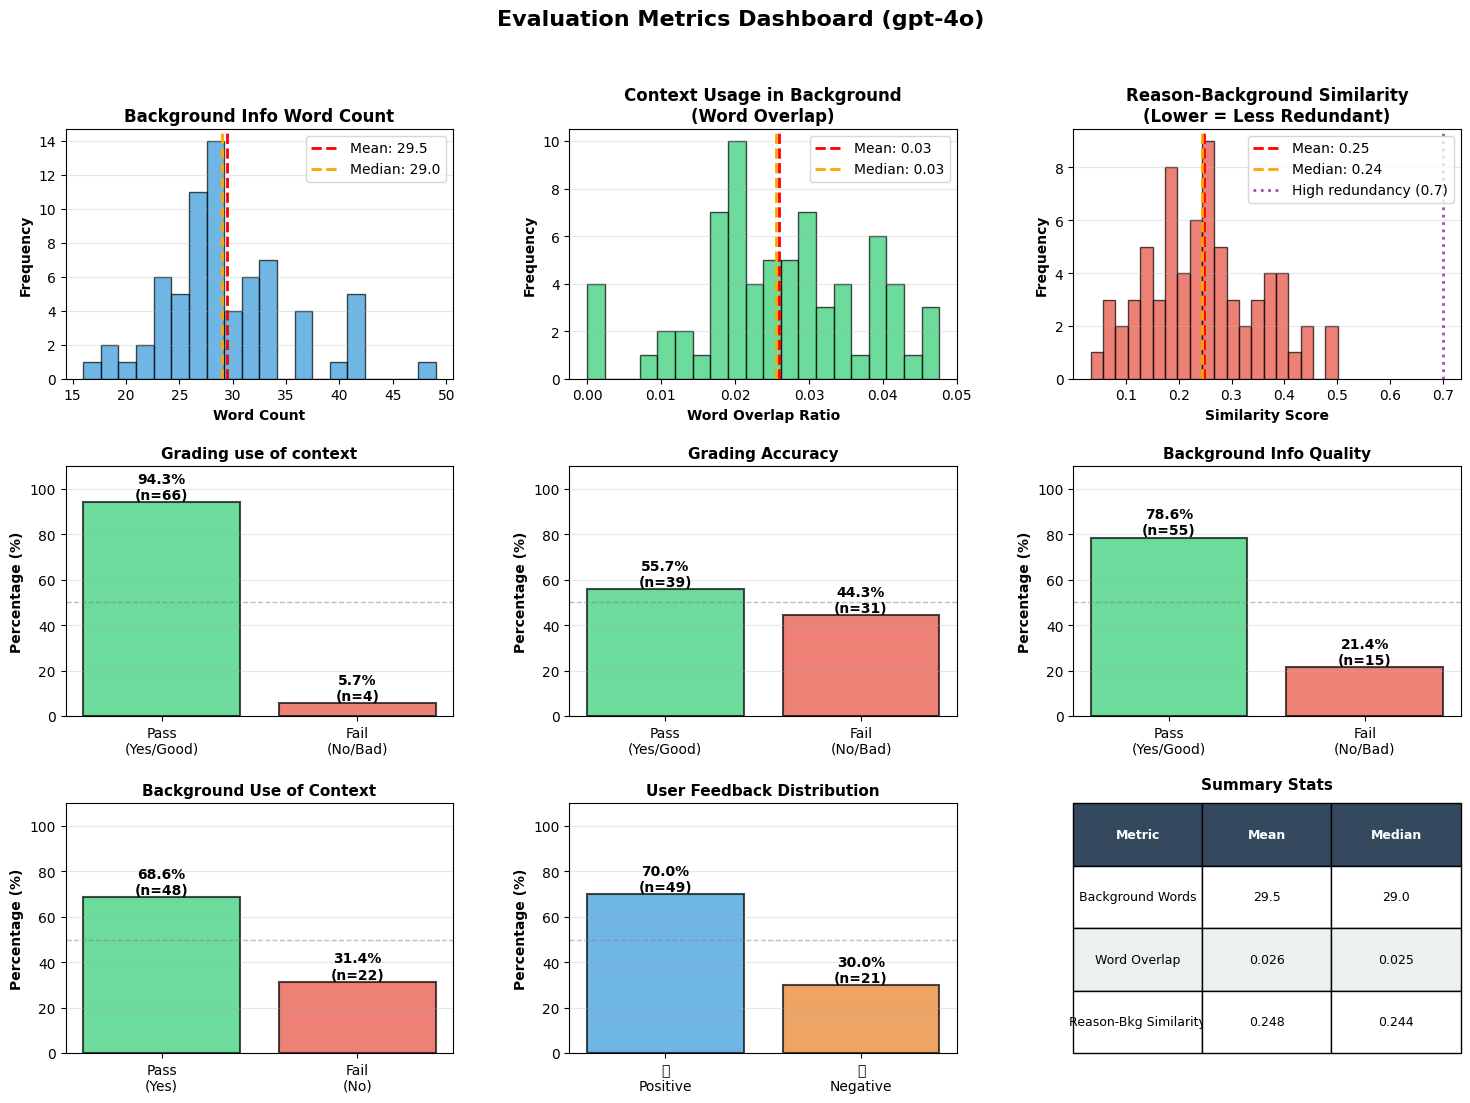

In [45]:
df = df_eval_gpt_4o.copy()

# Convert LLM judge metrics to binary
df['answer_context_binary'] = df['llm_judge_answer_context_usage'].apply(convert_to_binary)
df['grading_accuracy_binary'] = df['llm_judge_grading_accuracy'].apply(convert_to_binary)
df['background_quality_binary'] = df['llm_judge_background_info_quality'].apply(convert_to_binary)
df['background_context_binary'] = df['background_context_usage'].apply(convert_to_binary)

# Create figure
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

fig.suptitle('Evaluation Metrics Dashboard (gpt-4o)', fontsize=16, fontweight='bold', y=0.98)

# ============================================================================
# ROW 1: Continuous Metrics (Histograms)
# ============================================================================

# 1. Background Word Count
ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(df['background_info_word_count'].dropna(), bins=20, color='#3498db', alpha=0.7, edgecolor='black')
ax1.axvline(df['background_info_word_count'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {df['background_info_word_count'].mean():.1f}")
ax1.axvline(df['background_info_word_count'].median(), color='orange', linestyle='--', linewidth=2, label=f"Median: {df['background_info_word_count'].median():.1f}")
ax1.set_xlabel('Word Count', fontweight='bold')
ax1.set_ylabel('Frequency', fontweight='bold')
ax1.set_title('Background Info Word Count', fontweight='bold', fontsize=12)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. Context Usage (Word Overlap)
ax2 = fig.add_subplot(gs[0, 1])
ax2.hist(df['word_overlap'].dropna(), bins=20, color='#2ecc71', alpha=0.7, edgecolor='black')
ax2.axvline(df['word_overlap'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {df['word_overlap'].mean():.2f}")
ax2.axvline(df['word_overlap'].median(), color='orange', linestyle='--', linewidth=2, label=f"Median: {df['word_overlap'].median():.2f}")
ax2.set_xlabel('Word Overlap Ratio', fontweight='bold')
ax2.set_ylabel('Frequency', fontweight='bold')
ax2.set_title('Context Usage in Background\n(Word Overlap)', fontweight='bold', fontsize=12)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Reason-Background Similarity
ax3 = fig.add_subplot(gs[0, 2])
ax3.hist(df['reason_bkg_info_similarity'].dropna(), bins=20, color='#e74c3c', alpha=0.7, edgecolor='black')
ax3.axvline(df['reason_bkg_info_similarity'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {df['reason_bkg_info_similarity'].mean():.2f}")
ax3.axvline(df['reason_bkg_info_similarity'].median(), color='orange', linestyle='--', linewidth=2, label=f"Median: {df['reason_bkg_info_similarity'].median():.2f}")
ax3.axvline(0.7, color='purple', linestyle=':', linewidth=2, alpha=0.7, label='High redundancy (0.7)')
ax3.set_xlabel('Similarity Score', fontweight='bold')
ax3.set_ylabel('Frequency', fontweight='bold')
ax3.set_title('Reason-Background Similarity\n(Lower = Less Redundant)', fontweight='bold', fontsize=12)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# ============================================================================
# ROW 2: LLM Judge Binary Metrics (Bar Charts with Pass/Fail)
# ============================================================================

llm_metrics = [
    ('answer_context_binary', 'Grading use of context', 'llm_judge_answer_context_usage'),
    ('grading_accuracy_binary', 'Grading Accuracy', 'llm_judge_grading_accuracy'),
    ('background_quality_binary', 'Background Info Quality', 'llm_judge_background_info_quality')
]

for idx, (binary_col, title, original_col) in enumerate(llm_metrics):
    ax = fig.add_subplot(gs[1, idx])
    
    # Count pass/fail
    pass_count = (df[binary_col] == 1).sum()
    fail_count = (df[binary_col] == 0).sum()
    total = pass_count + fail_count
    
    pass_pct = pass_count / total * 100 if total > 0 else 0
    fail_pct = fail_count / total * 100 if total > 0 else 0
    
    # Plot
    categories = ['Pass\n(Yes/Good)', 'Fail\n(No/Bad)']
    values = [pass_pct, fail_pct]
    colors = ['#2ecc71', '#e74c3c']
    
    bars = ax.bar(categories, values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    
    # Add count labels
    for bar, count in zip(bars, [pass_count, fail_count]):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.1f}%\n(n={count})',
               ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_ylabel('Percentage (%)', fontweight='bold')
    ax.set_title(title, fontweight='bold', fontsize=11)
    ax.set_ylim(0, 110)
    ax.axhline(y=50, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax.grid(axis='y', alpha=0.3)

# ============================================================================
# ROW 3: Background Context Usage + User Feedback + Summary Stats
# ============================================================================

# 4. Background Context Usage
ax4 = fig.add_subplot(gs[2, 0])

pass_count = (df['background_context_binary'] == 1).sum()
fail_count = (df['background_context_binary'] == 0).sum()
total = pass_count + fail_count

pass_pct = pass_count / total * 100 if total > 0 else 0
fail_pct = fail_count / total * 100 if total > 0 else 0

categories = ['Pass\n(Yes)', 'Fail\n(No)']
values = [pass_pct, fail_pct]
colors = ['#2ecc71', '#e74c3c']

bars = ax4.bar(categories, values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

for bar, count in zip(bars, [pass_count, fail_count]):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
           f'{height:.1f}%\n(n={count})',
           ha='center', va='bottom', fontsize=10, fontweight='bold')

ax4.set_ylabel('Percentage (%)', fontweight='bold')
ax4.set_title('Background Use of Context', fontweight='bold', fontsize=11)
ax4.set_ylim(0, 110)
ax4.axhline(y=50, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax4.grid(axis='y', alpha=0.3)

# 5. USER FEEDBACK (NEW!)
ax5 = fig.add_subplot(gs[2, 1])

positive_count = (df['feedback_type'] == 'positive').sum()
negative_count = (df['feedback_type'] == 'negative').sum()
total_feedback = positive_count + negative_count

positive_pct = positive_count / total_feedback * 100 if total_feedback > 0 else 0
negative_pct = negative_count / total_feedback * 100 if total_feedback > 0 else 0

categories = ['👍\nPositive', '👎\nNegative']
values = [positive_pct, negative_pct]
colors = ['#3498db', '#e67e22']

bars = ax5.bar(categories, values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

for bar, count in zip(bars, [positive_count, negative_count]):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
           f'{height:.1f}%\n(n={count})',
           ha='center', va='bottom', fontsize=10, fontweight='bold')

ax5.set_ylabel('Percentage (%)', fontweight='bold')
ax5.set_title('User Feedback Distribution', fontweight='bold', fontsize=11)
ax5.set_ylim(0, 110)
ax5.axhline(y=50, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax5.grid(axis='y', alpha=0.3)

# 6. Summary Statistics Table
ax6 = fig.add_subplot(gs[2, 2])
ax6.axis('off')

summary_data = [
    ['Metric', 'Mean', 'Median'],
    ['Background Words', 
     f"{df['background_info_word_count'].mean():.1f}",
     f"{df['background_info_word_count'].median():.1f}"],
    ['Word Overlap',
     f"{df['word_overlap'].mean():.3f}",
     f"{df['word_overlap'].median():.3f}"],
    ['Reason-Bkg Similarity',
     f"{df['reason_bkg_info_similarity'].mean():.3f}",
     f"{df['reason_bkg_info_similarity'].median():.3f}"],
]

table = ax6.table(cellText=summary_data, cellLoc='center', loc='center',
                 bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2.2)

# Style header row
for i in range(3):
    cell = table[(0, i)]
    cell.set_facecolor('#34495e')
    cell.set_text_props(weight='bold', color='white')

# Alternate row colors
for i in range(1, len(summary_data)):
    for j in range(3):
        cell = table[(i, j)]
        if i % 2 == 0:
            cell.set_facecolor('#ecf0f1')
        else:
            cell.set_facecolor('#ffffff')

ax6.set_title('Summary Stats', fontweight='bold', fontsize=11, pad=10)

plt.savefig('metrics_dashboard_gpt4o.png', dpi=300, bbox_inches='tight')
plt.show()

In [48]:
print("\n" + "="*80)
print("📊 EVALUATION METRICS SUMMARY (gpt-4o)")
print("="*80)

# ============================================================================
# QUANTITATIVE METRICS
# ============================================================================
print("\n#### Quantitative Metrics")
print("-" * 60)

# Positive Feedback Rate
positive_rate = get_positive_feedback_rate(df)
print(f"Positive Feedback Rate: {positive_rate:.1f}% ({positive_count}/{total_feedback})")

# Background Word Count
avg_word_count = df['background_info_word_count'].mean()
print(f"Average Background Word Count:    {avg_word_count:.1f} words")

# Context Usage (Word Overlap)
mean_overlap = df['word_overlap'].mean()
print(f"Mean Word Overlap:                {mean_overlap:.1%}")

# Reason-Background Similarity
mean_similarity = df['reason_bkg_info_similarity'].mean()
print(f"Mean Reason-Background Similarity: {mean_similarity:.2f}")

# ============================================================================
# QUALITATIVE METRICS (LLM-as-Judge)
# ============================================================================
print("\n#### Qualitative Metrics (LLM-as-Judge)")
print("-" * 60)

# Grading use of context (Answer Context Usage)
answer_context_pass = (df['answer_context_binary'] == 1).sum()
answer_context_total = df['answer_context_binary'].notna().sum()
answer_context_rate = answer_context_pass / answer_context_total * 100 if answer_context_total > 0 else 0
print(f"Grading use of context:           {answer_context_rate:.1f}% pass ({answer_context_pass}/{answer_context_total})")

# Grading Accuracy
grading_pass = (df['grading_accuracy_binary'] == 1).sum()
grading_total = df['grading_accuracy_binary'].notna().sum()
grading_rate = grading_pass / grading_total * 100 if grading_total > 0 else 0
print(f"Grading Accuracy:                 {grading_rate:.1f}% good ({grading_pass}/{grading_total})")

# Background Info Quality
background_quality_pass = (df['background_quality_binary'] == 1).sum()
background_quality_total = df['background_quality_binary'].notna().sum()
background_quality_rate = background_quality_pass / background_quality_total * 100 if background_quality_total > 0 else 0
print(f"Background Info Quality:          {background_quality_rate:.1f}% good ({background_quality_pass}/{background_quality_total})")

# Background Use of Context
background_context_pass = (df['background_context_binary'] == 1).sum()
background_context_total = df['background_context_binary'].notna().sum()
background_context_rate = background_context_pass / background_context_total * 100 if background_context_total > 0 else 0
print(f"Background Use of Context:        {background_context_rate:.1f}% yes ({background_context_pass}/{background_context_total})")

print("\n" + "="*80)


📊 EVALUATION METRICS SUMMARY (gpt-4o)

#### Quantitative Metrics
------------------------------------------------------------
Positive Feedback Rate: 70.0% (49/70)
Average Background Word Count:    29.5 words
Mean Word Overlap:                2.6%
Mean Reason-Background Similarity: 0.25

#### Qualitative Metrics (LLM-as-Judge)
------------------------------------------------------------
Grading use of context:           94.3% pass (66/70)
Grading Accuracy:                 55.7% good (39/70)
Background Info Quality:          78.6% good (55/70)
Background Use of Context:        68.6% yes (48/70)



## Performance improvement
We have extracted the main setup in this notebook and created an evaluation script (wip adding it into an automated pipeline that runs daily).

the evaluation script can be found (here)[../scripts/evaluate.py].

We have run this evaluation pipeline and tracked the performance of our chatbot via a dashboard (which you can find [here](https://us-citizenship-test.streamlit.app/Dashboard)), during the following situations:

- 2025-10-16: using the base `USCIS_OFFICER_SYSTEM_PROMPT_V0` that the chatbot is using as baseline performance.
- 2025-10-19: using an improved `USCIS_OFFICER_SYSTEM_PROMPT` where we have now added several examples (multi-shots) that address the 5 main problems described at the beginning of this document, as well as enforced guardrails on tone/redundancy reduction, etc. 

You can find both prompts in [here](../utils/prompts.py).

The [dashboard](https://us-citizenship-test.streamlit.app/Dashboard) shows that there is a marked improvement across all our 7 metrics, meaning that the new prompt is better, and therefore becoming the default for all future chatbot deployments.

## Final thoughts
This evaluation notebook has set up the base performance when using the current prompt, and has looked into
- how well the metrics align with user sentiment
- the best setup for the best evaluation performance

Anything involving AI requires continuous improvement. It is necessary to both develop robust metrics that align with the user sentiment, as well as a good monitoring setup, to reliably track the performance improvement (or deterioration) of any AI-driven tool.